# Optimal Transport Project

MVA 2021-2022

Nicolás Violante

In [ ]:
!pip install POT
!pip install --upgrade numpy

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import itertools
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import cv2 as cv
from time import time
import os
import pickle

torch.manual_seed(42)
np.random.seed(42)

device = "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Car dataset


In [ ]:
CAR_DATASET_PATH = '/content/drive/My Drive/Colab Notebooks/optimal_transport/datasets/car/car.data'
data = pd.read_csv(CAR_DATASET_PATH)
data.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "label"]
data["buying"] = data["buying"].replace(["low", "med", "high", "vhigh"], [0, 1, 2, 3])
data["maint"] = data["maint"].replace(["low", "med", "high", "vhigh"], [0, 1, 2, 3])
data["doors"] = data["doors"].replace(["2", "3", "4", "5more"], [2, 3, 4, 5])
data["persons"] = data["persons"].replace(["2", "3", "more"], [2, 3, 4])
data["lug_boot"] = data["lug_boot"].replace(["small", "med", "big"], [0, 1, 2])
data["safety"] = data["safety"].replace(["low", "med", "high"], [0, 1, 2])
data["label"] = data["label"].replace(["unacc", "acc", "good"], [0, 1, 2])


# # Balanced dataset
# all_targets = data["label"].values
# indices_unacc = np.random.choice(np.where(all_targets == 0)[0], 134)
# indices_acc = np.random.choice(np.where(all_targets == 1)[0], 134)
# indices_good = np.where(all_targets == 2)[0]
# data = data.iloc[np.concatenate((indices_unacc, indices_acc, indices_good))]

# CAR_DATASET_BALANCED_PATH = '/content/drive/My Drive/Colab Notebooks/optimal_transport/datasets/car/balanced.csv'
# data.to_csv(CAR_DATASET_BALANCED_PATH)

In [ ]:
CAR_DATASET_BALANCED_PATH = '/content/drive/My Drive/Colab Notebooks/optimal_transport/datasets/car/balanced.csv'
data = pd.read_csv(CAR_DATASET_BALANCED_PATH)

In [ ]:
# Conert to PyTorch + Train/Test split
y = data["label"].values.astype(np.float32)
X = data[["buying", "maint", "doors", "persons", "lug_boot", "safety"]].to_numpy().astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)

# Convert everyting to Torch Tensors
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.tensor(y_train).to(device)
y_test = torch.tensor(y_test).to(device)

# Utils 

In [ ]:
def accuracy(y_pred, y_true):
    return (torch.sum(y_pred == y_true) / len(y_true)).item()

In [ ]:
def get_confusion_matrix_plot(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(9, 9))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix", fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=15, weight='light')
    plt.yticks(tick_marks, class_names, fontsize=15, weight='light')
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, f"{cm[i, j]:.3f}", horizontalalignment="center", color=color,fontsize=15)
        
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()
    plt.close()
    return figure


def confusion_matrix_plot_as_array(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    figure = get_confusion_matrix_plot(cm, class_names)
    figure.canvas.draw()
    cm_plot_array = cv.cvtColor(np.array(figure.canvas.renderer.buffer_rgba()), cv.COLOR_RGBA2RGB)
    return cm_plot_array

In [ ]:
def plot_training(logs):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(np.linspace(0, len(logs["train loss"]), len(logs["train acc"])), logs["train acc"], label="train")
    plt.plot(np.linspace(0, len(logs["train loss"]), len(logs["test acc"])), logs["test acc"], label="test")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(np.linspace(0, len(logs["train loss"]), len(logs["train loss"])), logs["train loss"], label="train")
    plt.plot(np.linspace(0, len(logs["train loss"]),len(logs["test loss"])), logs["test loss"], label="test")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()

def plot_cm(model, data, labels=["unacc", "acc", "good"]):
    X_train, X_test, y_train, y_test = data
    cm_train = confusion_matrix_plot_as_array(y_train.cpu().numpy(), model(X_train).argmax(dim=1).cpu().numpy(), labels)
    cm_test = confusion_matrix_plot_as_array(y_test.cpu().numpy(), model(X_test).argmax(dim=1).cpu().numpy(), labels)

    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.title("Train")
    plt.imshow(cm_train)
    plt.axis("off")
    plt.subplot(122)
    plt.title("Test")
    plt.imshow(cm_test)
    plt.axis("off")
    # plt.tight_layout()

# Baseline Neural Network

In [ ]:
class Baseline(nn.Module):
  def __init__(self, input_size=6, output_size=3):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(input_size, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, output_size),
    )
  def forward(self, x):
    return self.layers(x)


# class Baseline(nn.Module):
#   def __init__(self, input_size=6, output_size=3):
#     super().__init__()
#     self.layers = nn.Sequential(
#         nn.Linear(input_size, 8),
#         nn.ReLU(),
#         nn.Linear(8, 8),
#         nn.ReLU(),
#         nn.Linear(8, output_size),
#     )
#   def forward(self, x):
#     return self.layers(x)


# class Baseline(nn.Module):
#   def __init__(self, input_size=6, output_size=3):
#     super().__init__()
#     self.layers = nn.Sequential(
#         nn.Linear(input_size, output_size)
#     )
#   def forward(self, x):
#     return self.layers(x)

In [ ]:
def train(model, criterion, data, epochs=500, lr=0.001):
    X_train, X_test, y_train, y_test = data
    optimizer = optim.Adam(model.parameters(), lr=lr)
    logs = {"train loss": [],
            "test loss": [],
            "train acc": [],
            "test acc": [],
            "loss_time": []}
    labels = nn.functional.one_hot(y_train).float()
    names = {"apply": "WassersteinLoss",
             "cross_entropy": "CrossEntropyLoss"}
    use_softmax = names[criterion.__name__] == "WassersteinLoss"

    for epoch in range(epochs):
        # Training step
        optimizer.zero_grad()
        logits = model(X_train)
        tic = time()
        if use_softmax:
            loss = criterion(nn.functional.softmax(logits), labels)
        else:
            loss = criterion(logits, labels)
        toc = time()
        loss.backward()
        optimizer.step()
        logs["train loss"].append(loss.item())
        logs["loss_time"].append(toc-tic)

        # Validation step + Loss evolution
        if epoch % 50 == 0:
            with torch.no_grad():

                # Compute  accuracy
                logs["train acc"].append(accuracy(model(X_train).argmax(1), y_train))
                logs["test acc"].append(accuracy(model(X_test).argmax(1), y_test))

                if use_softmax:
                    logs["test loss"].append(criterion(nn.functional.softmax(model(X_test)), 
                                                    nn.functional.one_hot(y_test).float()).item())
                else:
                    logs["test loss"].append(criterion(model(X_test), 
                                                       nn.functional.one_hot(y_test).float()).item())
                print(f'[{epoch}/{epochs}]: train loss {logs["train loss"][-1]:.4f}, test loss {logs["test loss"][-1]:.4f}, et {logs["loss_time"][-1]:.4f}')
    return logs

# Wasserstein Loss

In [ ]:
class WassersteinLoss(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs, targets):
        x, y = inputs, targets
        lamb = 50.0
        num_iterations = 10
        b, n = x.shape[:2]
        m = n
        device = inputs.device

        # a = torch.cdist(torch.linspace(0,1,3)[:, None].float(), torch.linspace(0,1,3)[:, None].float())
        a = torch.tensor([[0.0, 1.0, 0.0],
                         [1.0, 0.0, 1.0],
                         [0.0, 1.0, 0.0]])
        M = torch.repeat_interleave(a[None, :,:], b, 0).to(device)
        K = torch.exp(- lamb * M - 1).to(device)   

        # Sinkhorn algorithm
        u = torch.ones((b,m,1)).to(device)
        for iter in range(num_iterations):
            term1 = (y[:,:,None] / torch.bmm(torch.transpose(K, 1, 2), u))
            term2 = torch.bmm(K, term1)
            u = x[:,:,None] / term2

        v = y[:,:,None] / torch.bmm(torch.transpose(K, 1, 2), u)

        # Wasserstein loss
        W_loss = torch.mean(torch.tensor([torch.einsum('ik,ij,jk,ij->k', u[i], K[i], v[i], M[i]).item() for i in range(b)]))

        # Gradient
        u = u[:,:,0] # remove dummy dim
        ctx.save_for_backward(u)
        return W_loss

    @staticmethod
    def backward(ctx, grad_outputs):
        lamb = 50.0
        u,  = ctx.saved_tensors
        gradW = torch.log(u + 1e-15) / lamb - torch.log(u.sum(1, keepdim=True) + 1e-15) / (lamb * u.shape[1])
        return gradW, None

# Sinkhorn divergence

In [ ]:
class SinkhornDivergence(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs, targets):
        x, y = inputs, targets
        
        lamb = 50
        W_loss1, u, _ = sinkhorn(x, y, lamb)
        W_loss_x, u_x, v_x = sinkhorn(x, x, lamb)
        W_loss_y, _, _ = sinkhorn(y, y, lamb)
        ctx.save_for_backward(u, u_x, v_x)
        W_loss = W_loss1 - 0.5 * (W_loss_x - W_loss_y)
        return W_loss

    @staticmethod
    def backward(ctx, grad_outputs):
        lamb = 50
        u, u_x, v_x, = ctx.saved_tensors
        gradW_u = torch.log(u + 1e-15) / lamb - torch.log(u.sum(1, keepdim=True) + 1e-15) / (lamb * u.shape[1])
        gradW_x = torch.log(u_x + 1e-15) / lamb - torch.log(u_x.sum(1, keepdim=True) + 1e-15) / (lamb * u_x.shape[1])
        gradW_x += torch.log(v_x + 1e-15) / lamb - torch.log(v_x.sum(1, keepdim=True) + 1e-15) / (lamb * v_x.shape[1])
        gradW = gradW_u + 0.5 * gradW_x
        return gradW, None

def sinkhorn(x, y, lamb):
    num_iterations = 10
    b, n = x.shape[:2]
    m = n
    device = x.device
    num_iterations = 10

    a = torch.cdist(torch.linspace(0,1,3)[:, None].float(), torch.linspace(0,1,3)[:, None].float())
    M = torch.repeat_interleave(a[None, :,:], b, 0).to(device)
    K = torch.exp(- lamb * M - 1).to(device)   

    u = torch.ones((b,m,1)).to(device)
    for iter in range(num_iterations):
        term1 = (y[:,:,None] / torch.bmm(torch.transpose(K, 1, 2), u))
        term2 = torch.bmm(K, term1)
        u = x[:,:,None] / term2
    v = y[:,:,None] / torch.bmm(torch.transpose(K, 1, 2), u)

    # Wasserstein loss
    W_loss = torch.mean(torch.tensor([torch.einsum('ik,ij,jk,ij->k', u[i], K[i], v[i], M[i]).item() for i in range(b)]))

    # Gradient
    u = u[:,:,0] # remove dummy dim
    v = v[:,:,0]

    return W_loss, u, v

In [ ]:
model_name = 'sk_unbalanced2'
model = Baseline()
# criterion = nn.functional.cross_entropy
criterion = SinkhornDivergence.apply
logs = train(model, criterion, (X_train, X_test, y_train, y_test), epochs=1000)

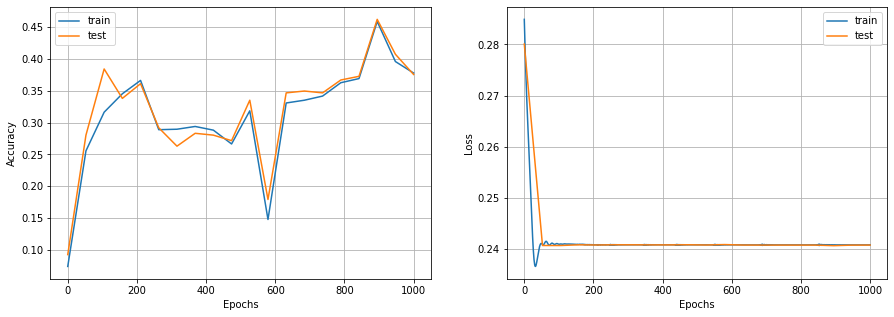

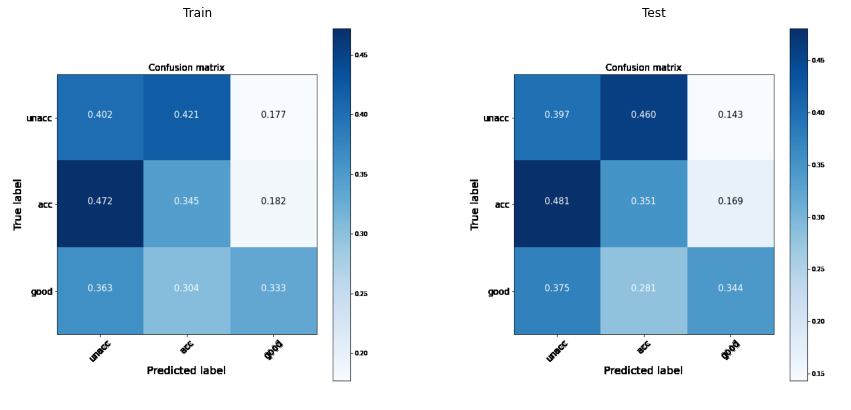

In [ ]:
plot_training(logs)
plot_cm(model, (X_train, X_test, y_train, y_test))

In [ ]:
MODELS_DIR = '/content/drive/My Drive/Colab Notebooks/optimal_transport/models/'
output_folder = MODELS_DIR + model_name

os.makedirs(output_folder, exist_ok=True)

model_path = os.path.join(output_folder, f'{model_name}.pt')
torch.save(model, model_path)

In [ ]:
DICT_PATH = os.path.join(MODELS_DIR, model_name, "dict.pickle")
with open(DICT_PATH, 'wb') as handle:
    pickle.dump(logs, handle, protocol=pickle.HIGHEST_PROTOCOL)